<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Machine Learning from End to End </span> </h1>
<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"> Employee Retention: A Classification Problem, Part 4: Model Training</h1>
<hr>

### In this module...

At last, it's time to build the models! First, I'll load the analytical base table from Part 2. Then, I'll go through the essential modeling steps:

1. [Split the dataset](#split)
2. [Build model pipelines](#pipelines)
3. [Declare hyperparameters to tune](#hyperparameters)
4. [Fit and tune models with cross-validation](#fit-tune)
5. [Evaluation metrics](#evaluate)
6. [Area under ROC curve](#auroc)

Finally, I'll save the best model to use in the next module. I'll spend a little extra time on the last 2 steps because classification tasks require new metrics.

<br><hr>

### First, let's import libraries, recruit models, and load the ABT.

First, let's import the libraries that we'll need.

In [1]:
# Computing libraries 
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn for Modeling
import sklearn

# Pickle for saving model files
import pickle

Next, let's import the algorithms I have selected for this project. Given that this is a bivariate classification problem I have decided to go with Logistic Regression, Random Forest, and Boosted Tree algorithms.

In [2]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Next, let's import the Scikit-Learn functions and helpers we'll need for this module.

In [3]:
# sklearn modules for model training
# includes modules for splitting training and test set, pipeline creation, standardization, cross-validation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Classification metrics for model performance evaluation
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

Finally, let's read the analytical base table I saved at the end of Part 2.

In [4]:
# Load analytical base table from Module 2
abt_df = pd.read_csv('analytical_base_table.csv')

<span id="split"></span>
# 1. Split the dataset

I'll start by splitting the data into separate training and test sets. Splitting into test/train sets helps us to minimize the chances of our models overfitting the data by making sure some data is set aside for testing model performance instead of all the data being used to train the model. For this problem I will separate the dataframe into separate objects for the target variable <code style="color:steelblue">y</code>, and the input features, <code style="color:steelblue">X</code>.

Once I've created my target variable and feature objects I then use the <code style="color:steelblue">train_test_split()</code> function to split <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> into training and test sets. I choose to set aside 20% of the observations for the test set, set a <code style="color:steelblue">random_state</code> variabel to ensure replicable results. Most importantly, I pass the argument <code style="color:steelblue">stratify=</code><span style="color:crimson">df.status</span></code> to make sure the target variable's classes are balanced in each subset of data so that we have **stratified random sampling**. This ensures that each of my divided subsets are truly random and the performance I get from my cross-validation is truly representative of my entire training data set. At the end I pring the nubmer of observations in each subset to check that the splitting was done correctly.

In [5]:
# Create separate object for target variable
y = abt_df.status

# Create separate object for input features
X = abt_df.drop('status', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=abt_df.status)

# Print number of observations in X_train, X_test, y_train, and y_test
print('X_train size:', len(X_train))
print('X_test size:', len(X_test))
print('y_train size:', len(y_train))
print('y_test size:', len(y_test))

X_train size: 11254
X_test size: 2814
y_train size: 11254
y_test size: 2814


<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="pipelines"></span>
# 2. Build model pipelines

Next, let's set up preprocessing pipelines for each of our algorithms. I use the keys below for each algorithm in my dictionary. Each pipeline is standardized first before the algorithm is run. Scaling the data sets so they all have a normal distribution centered around zero prevents any large scaling differences in the data affecting the model performance. Lastly, I set the <code style="color:steelblue">random_state</code> variable for each algorithm to ensure replicable results.

* Pipeline dictionary keys:
    * <code style="color:crimson">'l1'</code> for $L_1$-regularized logistic regression
    * <code style="color:crimson">'l2'</code> for $L_2$-regularized logistic regression
    * <code style="color:crimson">'rf'</code> for random forest
    * <code style="color:crimson">'gb'</code> for gradient boosted tree.


In [6]:
# Pipeline dictionary
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="hyperparameters"></span>
# 3. Declare hyperparameters to tune

Next, let's declare hyperparameters to tune. I start off by listing the tuneable hyperparameters of the logistic pipeline. There are many listed but usually only one or two are needed for tuning to optimize performance. I declare these hyperparameter grids next for each algorithm. To finish, I create a hyperparameter dictionary which uses the same keys of the pipeline dictionary I created above to store them all. Having both the pipelines and the hyperparameters in dictionary form will make the cross-validation step very straightforward.

In [7]:
# List tuneable hyperparameters of our Logistic pipeline
pipelines['l1'].get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=123, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 123,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': Tru

In [8]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C': np.linspace(1e-3, 1e3, 10),
}
l2_hyperparameters = {
    'logisticregression__C': np.linspace(1e-3, 1e3, 10),
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5],
}

In [9]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1': l1_hyperparameters,
    'l2': l2_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters,
}

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="fit-tune"></span>
# 4. Fit and tune models with cross-validation

Now that we have our <code style="color:steelblue">pipelines</code> and <code style="color:steelblue">hyperparameters</code> dictionaries declared, we're ready to tune our models with **cross-validation**.

For this task I start by creating an empty <code style="color:SteelBlue">fitted_models</code> dictionary that will include models that have been tuned using cross-validation. The keys will be the same as those in the <code style="color:SteelBlue">pipelines</code> and <code style="color:SteelBlue">hyperparameters</code> dictionaries. The values will be <code style="color:steelblue">GridSearchCV</code> objects that have been fitted to <code style="color:steelblue">X_train</code> and <code style="color:steelblue">y_train</code>. After fitting each model, I will print <code style="color:crimson">'{name} has been fitted.'</code> just to track the progress. To speed up processing time I set <code style="color:steelblue">n_jobs=<span style="color:crimson">-1</span></code> to use as many cores as available on my computer.

In [10]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.
gb has been fitted.


<span id="evaluate"></span>
# 5. Evaluation metrics

Finally, it's time to evaluate our models and pick the best one. Here I create a for loop which calculates the <code style="color:steelblue">best\_score_</code> attribute for each fitted model. As you can see, the ensemble tree algorithms had the best performance with Random Forest model getting the highest score followed by Boosted Trees and then the two Logistic Regression models. 

In [11]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)    

l1 0.8493868846632309
l2 0.8493868846632309
rf 0.979651679402879
gb 0.9752088146436823


<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

<span id="auroc"></span>
# 6. Area under ROC curve

**Area under ROC curve** is the most reliable metric for classification tasks.


Before presenting the idea of an ROC curve, we must first discuss what a **confusion matrix** is. This is essentially a chart that gives probabilities of false positives, true positives, false negatives, and true negatives so that we have deeper visibility into the performance of our models. 

Let's see an example using our $L_1$-regularized logistic regression. First, I'll use <code style="color:steelblue">.predict()</code> to get the predicted classes directly. Then I'll print out the confusion matrix directly.

In [12]:
# Predict classes using L1-regularized logistic regression 
pred = fitted_models['l1'].predict(X_test)

# Display first 5 predictions
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [13]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix

# Display confusion matrix for y_test and pred
print(confusion_matrix(y_test, pred))

[[1969  172]
 [ 221  452]]


We can predict a **probability** for each class using <code style="color:steelblue">.predict_proba()</code>, instead of the class directly.

For example:

In [14]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l1'].predict_proba(X_test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 5 predictions
pred[:10]

[0.03057007025714808,
 0.004441966482297899,
 0.007296300193244648,
 0.08809786580386156,
 0.07115095012841731,
 0.48160946301549457,
 0.12604877174578802,
 0.615294689491269,
 0.72665929094601,
 0.1370359554428753]

Let's calculate the ROC curve using the <code style="color:steelblue">roc_curve()</code> function that we imported earlier.

In [15]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

We can throw these into a DataFrame for convenience and look at the last 10:

In [16]:
# Store fpr, tpr, thresholds in DataFrame and display last 10
pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds}).tail(10)

,FPR,TPR,Thresholds
532,0.759925,0.994056,0.009627
533,0.784680,0.994056,0.008120
534,0.784680,0.995542,0.008076
535,0.910322,0.995542,0.001962
536,0.910322,0.997028,0.001950
537,0.932742,0.997028,0.001393
538,0.932742,0.998514,0.001388
539,0.949089,0.998514,0.001051
540,0.949089,1.000000,0.001040
541,1.000000,1.000000,0.000027


As you can see, as you decrease the threshold, both the false positive rate **and** the true positive rate increase.

We can plot the entire curve.

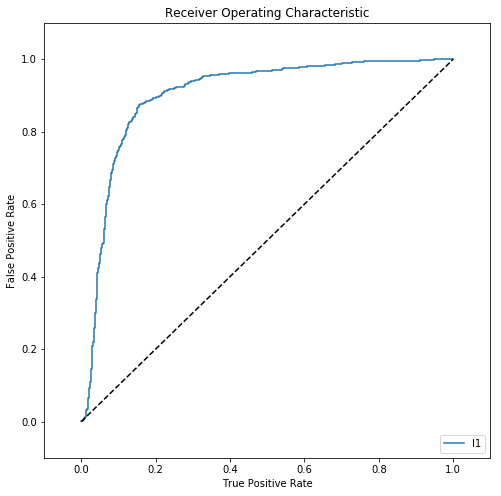

In [17]:
# Initialize figure
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1], [0,1], 'k--')

# Axes limits and labels
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()

To calculate AUROC, use the <code style="color:steelblue">auc()</code> function we imported earlier in conjunction with the <code style="color:steelblue">roc_curve()</code> function.

In [18]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred)
# Calculate AUROC
print(auc(fpr, tpr))

0.9015430014581235


Now that we've taken a detour to dive into some of the intuition behind AUROC, let's calculate it for each of our fitted models on the test set. I'm going to print the <code style="color:SteelBlue">auc</code> of the <code style="color:SteelBlue">roc_curve</code> and label the output with the name of the algorithm. Finally, I will save the winning <code style="color:steelblue">Pipeline</code> object into a pickle file.

In [19]:
# Code here
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name, auc(fpr, tpr))

l1 0.9015430014581235
l2 0.9015388373737674
rf 0.9915201892159932
gb 0.9886802836851869


In [20]:
# Save winning model as final_model.pkl
with open ('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>

## Next Steps

As a reminder, here are a few things we did in this module:
* Split the dataset into training and test sets.
* Set up model pipelines and hyperparameter grids.
* Tuned the models using cross-validation.
* Learned about how AUROC is a more effective metric for classification than simple accuracy.
* Saved the winning model.

In the next module, <span style="color:royalblue">Part 4: Project Delivery</span>, we'll see how we can go the extra mile in terms of project delivery. That includes preparing to apply the model to raw data and packaging it up into an executable script.

<p style="text-align:center; margin: 40px 0 40px 0; font-weight:bold">
<a href="#toc">Back to Contents</a>
</p>